In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import csv

def organize_graph_and_add_weight(file_path, label):
    """Your graph preprocessor — same as you have."""
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x

import torch
import pandas as pd

def get_important_edges_from_npy(
    npy_file,
    model, 
    device
):
    """
    Load a graph from .npy, run GAT, compute Attention × Gradient importance.
    Return both the DataFrame and the encoded_matrix!
    """
    # === Load graph ===
    data = np.load(npy_file, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    # Build PyG Data
    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0] 
    y = torch.tensor([1.0], dtype=torch.float32)

    from torch_geometric.data import Data
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    batch = torch.zeros(graph.x.size(0), dtype=torch.long)

    graph = graph.to(device)
    batch = batch.to(device)

    graph.batch = batch

    graph.edge_attr = graph.edge_attr.detach().clone().requires_grad_(True)
    
    # === Forward pass ===
    output = model(graph)
    edge_index = graph.edge_index
    # For a unified downstream path, treat edge weights as "alpha"
    alpha = graph.edge_attr

    # === Backward ===
    model.zero_grad()
    output[0].backward()

    alpha_importance = alpha * alpha.grad

    edge_src = edge_index[0].cpu().numpy().reshape(-1)
    edge_dst = edge_index[1].cpu().numpy().reshape(-1)
    #attention = alpha.detach().cpu().numpy().reshape(-1)
    grad = alpha.grad.detach().cpu().numpy().reshape(-1)
    importance = alpha_importance.detach().cpu().numpy().reshape(-1)

    df = pd.DataFrame({
        'source': edge_src,
        'target': edge_dst,
        #'attention': attention,
        'grad': grad,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    return df, encoded_matrix



In [60]:
def get_edge_node_features(df, encoded_matrix, top_k=5):
    biggest_set = [
        # Carbon (C) subtypes
        'C', 'CA', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3', 'CG', 'CG1', 'CG2', 'CH2', 'CZ', 'CZ2', 'CZ3',

        # Oxygen (O) subtypes
        'O', 'OH', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1',

        # Nitrogen (N) subtypes
        'N', 'NE', 'NE1', 'NE2', 'ND1', 'ND2', 'NZ', 'NH1', 'NH2',

        # Sulfur (S) subtypes
        'SD', 'SG'
    ]
    biggest_set.append('UNKNOWN')

    rows = []
    for _, row in df.head(top_k).iterrows():
        src_idx = int(row['source'])
        tgt_idx = int(row['target'])

        src_feat = encoded_matrix[src_idx]
        tgt_feat = encoded_matrix[tgt_idx]

        # Decode one-hot vector back to atom name
        def decode_one_hot(vector):
            idx = vector.argmax()
            return biggest_set[idx] if idx < len(biggest_set) else "INVALID"

        rows.append({
            'source_idx': src_idx,
            'target_idx': tgt_idx,
            #'attention': row['attention'],
            'grad': row['grad'],
            'importance': row['importance'],
            'source_features': src_feat,
            'target_features': tgt_feat,
            'source_atom': decode_one_hot(src_feat),
            'target_atom': decode_one_hot(tgt_feat)
        })

    return rows

In [61]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from Bio.PDB import PDBParser

# === Helpers ===
biggest_set = [
    'C', 'CA', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3', 'CG', 'CG1', 'CG2', 'CH2', 'CZ', 'CZ2', 'CZ3',
    'O', 'OH', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1',
    'N', 'NE', 'NE1', 'NE2', 'ND1', 'ND2', 'NZ', 'NH1', 'NH2',
    'SD', 'SG', 'UNKNOWN'
]

def decode_one_hot(vector):
    idx = vector.argmax()
    return biggest_set[idx] if idx < len(biggest_set) else "INVALID"

def get_atom_coords_and_residues(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("mol", pdb_file)
    atoms = []

    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.is_disordered():
                        # Add ALL conformers (A, B, etc.)
                        for alt_atom in atom.disordered_get_list():
                            atoms.append(alt_atom)
                    else:
                        atoms.append(atom)

    #print(f"Total atoms extracted: {len(atoms)}")
    coords = [atom.coord for atom in atoms]
    residues = [
        (
            atom.get_parent().get_resname(),              # residue name (e.g., LEU)
            atom.get_parent().get_id()[1],                # residue number
            atom.get_parent().get_parent().get_id()       # chain ID
        )
        for atom in atoms
    ]
    return coords, residues

def euclidean_distance(coord1, coord2):
    return np.linalg.norm(coord1 - coord2)

atom_counts_per_exp   = []   # list[Counter]
residue_counts_per_exp= []   # list[Counter]
distances_per_exp     = []   # list[list[float]]

In [62]:
# pre load models
def load_GCN(model_checkpoint, in_channels, out_channels, device):
    model = GCN(input_dim=37)
    state_dict = torch.load(model_checkpoint, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    return model

def natural_sort_key(s):
    """Function to sort strings in a natural alphanumeric order."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_models = []

model_pattern = '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp1 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp1)

model_pattern = '../../../Models/Cholesterol/GCN/GCN-5A_Exp2/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp2 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp2)

model_pattern = '../../../Models/Cholesterol/GCN/GCN-5A_Exp3/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp3 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp3)

model_pattern = '../../../Models/Cholesterol/GCN/GCN-5A_Exp4/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp4 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp4)

model_pattern = '../../../Models/Cholesterol/GCN/GCN-5A_Exp5/Models/*.pth'
model_paths = sorted(glob.glob(model_pattern), key=natural_sort_key)

print(model_paths[:15])
models_exp5 = [load_GCN(p, in_channels=37, out_channels=32, device=device) for p in model_paths]
all_models.append(models_exp5)

['../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_1.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_2.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_3.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_4.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_5.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_6.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_7.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_8.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_9.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_10.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_11.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_12.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_13.pth', '../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Models/model_bin_14.pth', '../../../Mode

In [63]:
#for exp_index, experiment_models in enumerate(all_models):
experiment_models = all_models[0]

atom_subtype_counter = Counter()
residue_type_counter_overall = Counter()
distance_list = []
edge_records = []  # put this BEFORE your big loops
per_file_rank_rows = []

#npy_files = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp{exp_index + 1}/Test/Positive/*.npy')
npy_files = glob.glob(f'/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/1_16-piezo-separate-graphs-5A/unlabeled/*.npy')
for index, npy_file in enumerate(npy_files):
    if index % 10 == 0:
        print("Progress:", index, "/", len(npy_files))
    #npy_file = "/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/1_16-piezo-separate-graphs-5A/unlabeled/boxCHL1_3277-filtered_graphs.npy"
    basename = os.path.basename(npy_file)
    pdb_file = f"/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/filtered-1_16-piezo-pdbs/unlabeled/{basename[:12]}-filtered.pdb"
    #pdb_file = f"../GNN/ivan-pdbs-distinct-5A/positive/{basename[:4]}-filtered.pdb"

    edge_counts = Counter()  # key: (min_idx, max_idx) -> count
    # Keep stats for tie-breaks and metadata
    edge_stats = defaultdict(lambda: {
        "importances": [],
        "grads": [],
        "src_atom": None,
        "tgt_atom": None,
    })

    residue_type_counter = Counter()

    coords, residues = get_atom_coords_and_residues(pdb_file)

    for model_index, model in enumerate(experiment_models):
        df, encoded_matrix = get_important_edges_from_npy(
            npy_file=npy_file,
            model=model,
            device=device
        )

        rows = get_edge_node_features(df, encoded_matrix, top_k=20)

        for r in rows:
            u = int(r['source_idx'])
            v = int(r['target_idx'])
            a, b = (u, v) if u < v else (v, u)  # undirected canonical key
            edge_counts[(a, b)] += 1

            # collect stats for tie-breaking & later reporting
            s = edge_stats[(a, b)]
            s["importances"].append(float(r.get("importance", 0.0)))
            s["grads"].append(float(r.get("grad", 0.0)))
            # store atom subtypes (last write wins; these should be consistent per node)
            s["src_atom"] = r.get("source_atom", s["src_atom"])
            s["tgt_atom"] = r.get("target_atom", s["tgt_atom"])
    if edge_counts:
        # sort keys by (-count, -mean_importance)
        def sort_key(k):
            cnt = edge_counts[k]
            imps = edge_stats[k]["importances"]
            mean_imp = float(np.mean(imps)) if len(imps) > 0 else 0.0
            return (-cnt, -mean_imp)

        top_keys = sorted(edge_counts.keys(), key=sort_key)[:20]

        # Only now update your counters and edge_records with these 5 edges (once per edge)
        for (a, b) in top_keys:
            # safe lookups
            src = a
            tgt = b

            if src < len(residues):
                src_res, src_num, src_chain = residues[src]
            else:
                src_res, src_num, src_chain = "UNK", -1, "UNK"

            if tgt < len(residues):
                tgt_res, tgt_num, tgt_chain = residues[tgt]
            else:
                tgt_res, tgt_num, tgt_chain = "UNK", -1, "UNK"


            # distance is fixed for this sample (same coords), so compute directly
            dist = euclidean_distance(np.array(coords[src]), np.array(coords[tgt]))

            # representative atom subtypes from stats (if available)
            src_atom = edge_stats[(a, b)]["src_atom"] if edge_stats[(a, b)]["src_atom"] is not None else "UNK"
            tgt_atom = edge_stats[(a, b)]["tgt_atom"] if edge_stats[(a, b)]["tgt_atom"] is not None else "UNK"

            # mean importance (optional but handy to store)
            mean_importance = float(np.mean(edge_stats[(a, b)]["importances"])) if edge_stats[(a, b)]["importances"] else 0.0

            if src_res == "ILE" and tgt_res == "ILE" and dist > 3.0:
                print(src_atom, "is source", tgt_atom, "is target", pdb_file, "is pdb", src, "is atom id for source", tgt, "is atom id for target", dist, "is distance")

            # Update counters ONCE per selected edge (not multiplied by frequency)
            atom_subtype_counter[src_atom] += 1
            atom_subtype_counter[tgt_atom] += 1
            residue_type_counter[f"{src_res}_{src_num}_{src_chain}"] += 1
            residue_type_counter[f"{tgt_res}_{tgt_num}_{tgt_chain}"] += 1
            distance_list.append(dist)

            # Save record
            edge_records.append({
                "src_idx": int(src),
                "tgt_idx": int(tgt),
                "src_res": src_res,
                "tgt_res": tgt_res,
                "importance": mean_importance,  # averaged across models for this sample
                "distance": float(dist),
                "frequency": int(edge_counts[(a, b)]),  # how many models surfaced this edge
                "sample_file": basename
            })
    if residue_type_counter:
        # Sort by frequency desc, then lexicographically for stable ties
        ranked = sorted(residue_type_counter.items(), key=lambda x: (-x[1], x[0]))
        for rank_i, (res_id, count) in enumerate(ranked, start=1):
            per_file_rank_rows.append({
                "filename": basename,
                "rank": rank_i,
                "residue": res_id,     # e.g., "LEU_45_A"
                "count": count
            })

    # ===== also update overall counters if you still want those aggregates =====
    residue_type_counter_overall.update(residue_type_counter)

# ===== write the per-file rankings CSV =====
csv_path = "residue_rankings_by_file.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["filename", "rank", "residue", "count"])
    writer.writeheader()
    writer.writerows(per_file_rank_rows)

print(f"Wrote per-file residue rankings to: {csv_path}")

# Keep your existing experiment-level aggregations if needed
atom_counts_per_exp.append(atom_subtype_counter_overall)
residue_counts_per_exp.append(residue_type_counter_overall)
distances_per_exp.append(distance_list)

Progress: 0 / 45
CD is source CG2 is target /home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/filtered-1_16-piezo-pdbs/unlabeled/boxCHL1_3589-filtered.pdb is pdb 4 is atom id for source 6 is atom id for target 3.197165 is distance
Progress: 10 / 45
CG2 is source CD is target /home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/filtered-1_16-piezo-pdbs/unlabeled/boxCHL1_3086-filtered.pdb is pdb 4 is atom id for source 6 is atom id for target 3.0453122 is distance
Progress: 20 / 45
Progress: 30 / 45
Progress: 40 / 45
Wrote per-file residue rankings to: residue_rankings_by_file.csv


In [64]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# ===== Helpers to save/load =====
def save_counters_to_csv(counters, filename):
    """
    counters: list of Counter objects (one per experiment)
    Saves to CSV with __experiment__ column + one column per key
    """
    df = pd.DataFrame(counters).fillna(0).astype(int)
    df.insert(0, "__experiment__", np.arange(1, len(df)+1))
    df.to_csv(filename, index=False)

def load_counters_from_csv(filename):
    """
    Loads CSV back into list of Counter dicts
    """
    df = pd.read_csv(filename)
    counters = []
    for _, row in df.iterrows():
        c = {col: int(row[col]) for col in df.columns if col != "__experiment__"}
        counters.append(c)
    return counters

def save_hists_to_csv(hists, bin_edges, filename):
    """
    hists: list of per-experiment hist arrays
    bin_edges: numpy array of bin edges
    Saves counts with __experiment__ + bin columns labeled by bin center
    """
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    df = pd.DataFrame(hists, columns=[f"bin_{c:.1f}" for c in bin_centers])
    df.insert(0, "__experiment__", np.arange(1, len(df)+1))
    df.to_csv(filename, index=False)

def load_hists_from_csv(filename):
    """
    Loads histogram CSV back into list of arrays + bin centers
    """
    df = pd.read_csv(filename)
    bin_cols = [c for c in df.columns if c != "__experiment__"]
    hists = df[bin_cols].to_numpy()
    bin_centers = [float(c.replace("bin_", "")) for c in bin_cols]
    return hists, np.array(bin_centers)

# # ===== Example usage with your data =====
# # Save
# save_counters_to_csv(atom_counts_per_exp, "CSV\'s/gcn_external_atom_counts_per_exp.csv")
# save_counters_to_csv(residue_counts_per_exp, "CSV\'s/gcn_external_residue_counts_per_exp.csv")
# #save_hists_to_csv(hists, bin_edges, "distance_hists.csv")

# # Load
# atom_counts_per_exp = load_counters_from_csv("CSV\'s/gcn_external_atom_counts_per_exp.csv")
# residue_counts_per_exp = load_counters_from_csv("CSV\'s/gcn_external_residue_counts_per_exp.csv")
# #hists, bin_centers = load_hists_from_csv("distance_hists.csv")

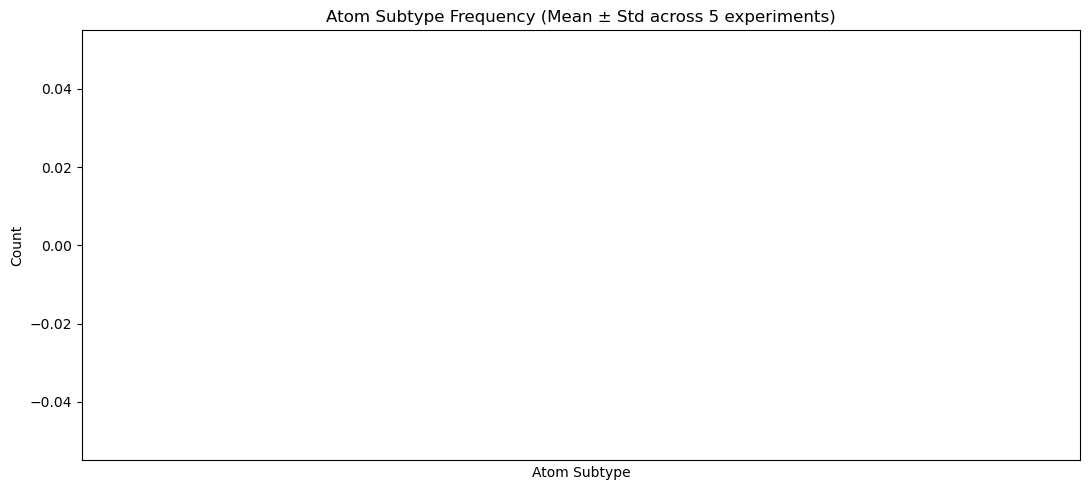

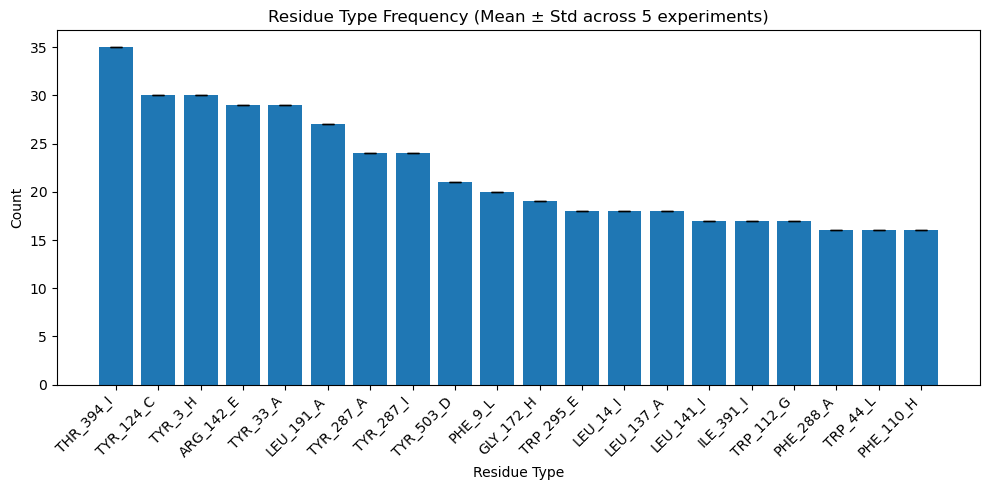

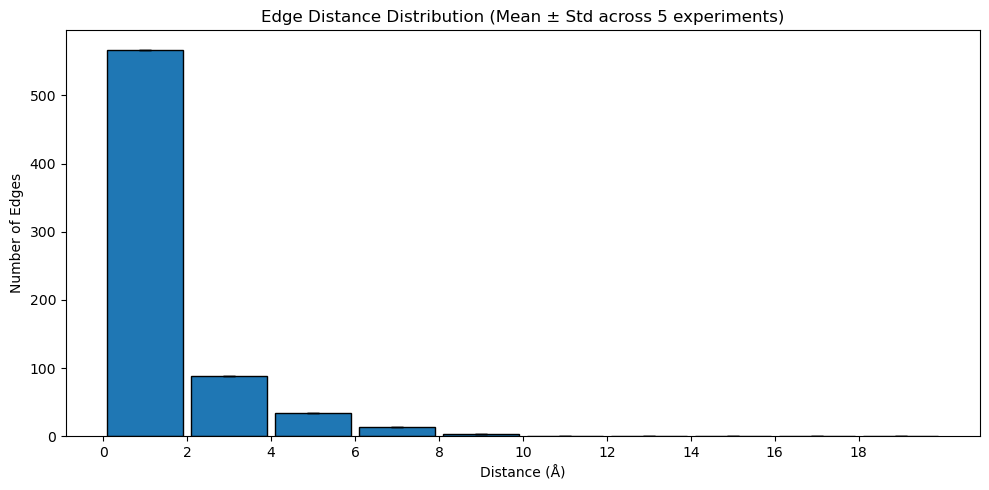

In [65]:
# ===== helper to compute mean/std across experiments for categorical bars =====
def mean_std_bars(counters, top_n=None):
    # union of all keys across experiments
    labels = sorted(set().union(*[c.keys() for c in counters]))
    mat = np.array([[c.get(lbl, 0) for lbl in labels] for c in counters], dtype=float)
    means = mat.mean(axis=0)
    stds  = mat.std(axis=0, ddof=1) if mat.shape[0] > 1 else np.zeros_like(means)
    order = np.argsort(-means)  # sort by mean desc

    if top_n is not None:
        order = order[:top_n]

    return [labels[i] for i in order], means[order], stds[order]

# ===== 1) Atom subtype: mean ± std =====
atom_labels, atom_means, atom_stds = mean_std_bars(atom_counts_per_exp)
plt.figure(figsize=(11, 5))
x = np.arange(len(atom_labels))
plt.bar(x, atom_means, yerr=atom_stds, capsize=4)
plt.xticks(x, atom_labels, rotation=90)
plt.title("Atom Subtype Frequency (Mean ± Std across 5 experiments)")
plt.xlabel("Atom Subtype")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ===== 2) Residue type: mean ± std =====
res_labels, res_means, res_stds = mean_std_bars(residue_counts_per_exp, top_n=20)
plt.figure(figsize=(10, 5))
x = np.arange(len(res_labels))
plt.bar(x, res_means, yerr=res_stds, capsize=4)
plt.xticks(x, res_labels, rotation=45, ha='right')
plt.title("Residue Type Frequency (Mean ± Std across 5 experiments)")
plt.xlabel("Residue Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ===== 3) Distance histogram: mean ± std per bin =====
# use a fixed bin width (2 Å to match your ticks)
bin_width = 2.0
all_dists = np.concatenate([np.array(d) for d in distances_per_exp]) if distances_per_exp else np.array([0.0])
max_d = math.ceil(all_dists.max()) if all_dists.size else 0
# ensure at least one bin
max_edge = max(bin_width, math.ceil(max_d / bin_width) * bin_width)
bin_edges = np.arange(0.0, max_edge + bin_width + 1e-9, bin_width)

# per-experiment hist counts with same bins
hists = []
for dlist in distances_per_exp:
    hist, _ = np.histogram(dlist, bins=bin_edges)
    hists.append(hist.astype(float))
H = np.vstack(hists) if hists else np.zeros((1, len(bin_edges)-1))
hist_means = H.mean(axis=0)
hist_stds  = H.std(axis=0, ddof=1) if H.shape[0] > 1 else np.zeros_like(hist_means)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
plt.figure(figsize=(10, 5))
plt.bar(bin_centers, hist_means, width=bin_width*0.9, yerr=hist_stds, capsize=4, align='center', edgecolor='black')
plt.title("Edge Distance Distribution (Mean ± Std across 5 experiments)")
plt.xlabel("Distance (Å)")
plt.ylabel("Number of Edges")
plt.xticks(np.arange(0, max_edge + 1e-9, 2.0))  # tick every 2 Å like before
plt.tight_layout()
plt.show()

Number of edges: 708
Plotting 708 edges


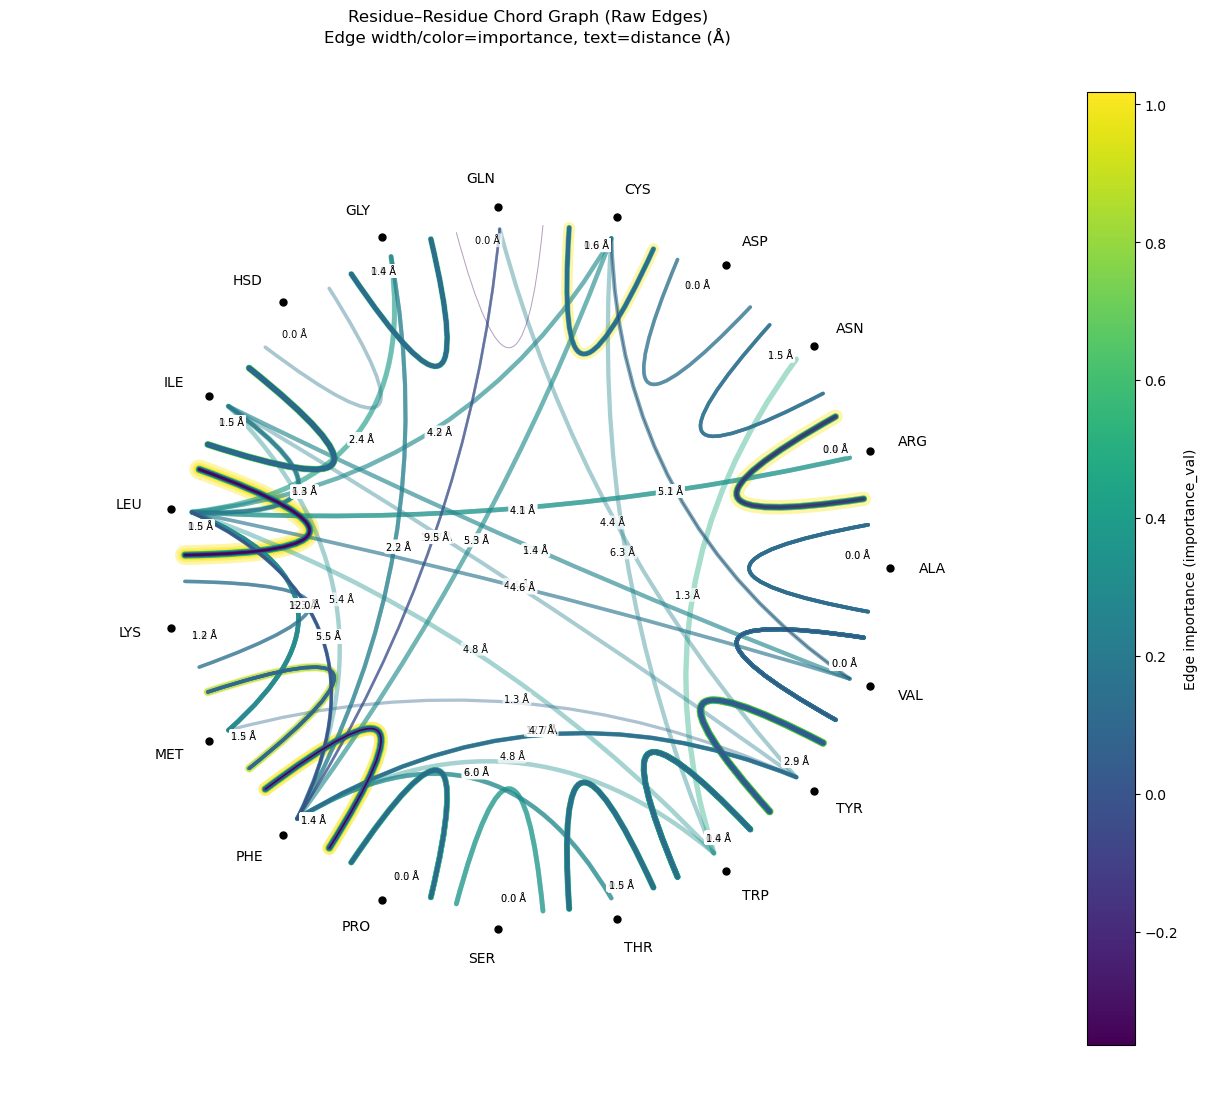

In [66]:
edges_df = pd.DataFrame(edge_records)
if edges_df.empty:
    raise ValueError("No edges collected; edge_records is empty.")

# Treat residue pairs as undirected, but keep all rows (no aggregation)
edges_df["res_a"] = edges_df.apply(lambda x: min(x["src_res"], x["tgt_res"]), axis=1)
edges_df["res_b"] = edges_df.apply(lambda x: max(x["src_res"], x["tgt_res"]), axis=1)

# For plotting, we'll use the raw per-edge values
edges_df["importance_val"] = edges_df["importance"]
edges_df["distance_val"]   = edges_df["distance"]

print(f"Number of edges: {len(edges_df['distance_val'])}")

def plot_residue_chord_raw(
    df,
    importance_col="importance_val",
    distance_col="distance_val",
    top_k=70000,
    node_order=None,
    figsize=(12, 12),
    node_label_size=10,
    edge_alpha=0.4,
    curvature=0.55,
    cmap_name="viridis",
    pad=0.35,
    node_inset=0.94,
    label_inset=0.97,
    clip_edges=True,
    dist_min=None,      # NEW
    dist_max=None       # NEW
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.path import Path
    from matplotlib.patches import PathPatch, Circle
    from matplotlib import colors

    # --- Distance filter (NEW) ---
    if dist_min is not None:
        df = df[df[distance_col] >= dist_min]
    if dist_max is not None:
        df = df[df[distance_col] <= dist_max]
        print("Not empty")

    if df.empty:
        raise ValueError("No edges to plot after distance filter.")

    df = df.sort_values(importance_col, ascending=False).head(top_k).copy()
    print(f"Plotting {len(df)} edges") 

    # Nodes
    nodes = node_order or sorted(set(df["res_a"]).union(set(df["res_b"])))
    if not nodes:
        raise ValueError("No nodes after filtering.")
    n = len(nodes)
    node_to_idx = {r: i for i, r in enumerate(nodes)}
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    R = 1.0
    coords = np.c_[R*np.cos(angles), R*np.sin(angles)]

    # Color scaling that actually uses the full colormap
    vals = df[importance_col].to_numpy().astype(float)
    if vals.size == 0:
        raise ValueError("No importance values to color.")
    # Use percentile clipping to avoid tiny dynamic range
    vmin, vmax = np.percentile(vals, 2), np.percentile(vals, 98)
    if vmin == vmax:
        vmin, vmax = vals.min(), vals.max()
    if vmin == vmax:
        vmin, vmax = 0.0, 1.0  # fallback
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap_name)
    def width_fn(v, mn=0.5, mx=6.0):
        return mn + (mx - mn) * ((v - vmin) / (vmax - vmin) if vmax > vmin else 0.5)
    def color_fn(v):
        return cmap(norm(v))

    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    ax.set_aspect("equal"); ax.axis("off")

    # Nodes + labels
    label_r = 1.08
    for i, r in enumerate(nodes):
        x, y = coords[i]
        ax.plot([x],[y],"o",ms=5,color="black")
        lx, ly = label_r*np.cos(angles[i]), label_r*np.sin(angles[i])
        ha = "left" if lx >= 0 else "right"
        ax.text(lx, ly, r, ha=ha, va="center", fontsize=node_label_size)

    clip_circle = Circle((0,0),1.0,transform=ax.transData) if clip_edges else None

    def _quad(p0, p1, p2, t):
        return (1-t)**2*p0 + 2*(1-t)*t*p1 + t**2*p2

    # Edges
    for _, row in df.iterrows():
        a = node_to_idx[row["res_a"]]; b = node_to_idx[row["res_b"]]
        if a == b: 
            p = coords[a] * node_inset
            # unit tangent perpendicular to radius
            t = p[::-1] * np.array([-1, 1])
            t = t / (np.linalg.norm(t) + 1e-12)
            loop_width = 0.12          # arc half-width along tangent
            loop_curv  = 0.70          # pull control toward center (0..1)
            p0 = p + t * loop_width
            p2 = p - t * loop_width
            p1 = (1.0 - loop_curv) * p  # inward control point

            verts = np.vstack([p0, p1, p2])
            codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
            path  = Path(verts, codes)

            w = width_fn(float(row[importance_col]))
            c = color_fn(float(row[importance_col]))
            patch = PathPatch(path, lw=w, edgecolor=c, facecolor="none",
                            alpha=edge_alpha, capstyle="round", clip_on=True)
            if clip_circle is not None:
                patch.set_clip_path(clip_circle)
            ax.add_patch(patch)

            # label near the loop
            mid_xy = (p + t * (loop_width * 0.3)) * label_inset
            txt = ax.text(mid_xy[0], mid_xy[1], f'{row[distance_col]:.1f} Å',
                        fontsize=7, ha="center", va="center",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))
            if clip_circle is not None:
                txt.set_clip_path(clip_circle)
            continue
        p0 = coords[a]*node_inset
        p2 = coords[b]*node_inset
        p_mid = 0.5*(p0+p2)
        p1 = (1.0-curvature)*p_mid
        verts = np.vstack([p0,p1,p2])
        codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
        path = Path(verts,codes)
        w = width_fn(float(row[importance_col]))
        c = color_fn(float(row[importance_col]))
        patch = PathPatch(path,lw=w,edgecolor=c,facecolor="none",
                          alpha=edge_alpha,capstyle="round",clip_on=True)
        if clip_circle is not None: patch.set_clip_path(clip_circle)
        ax.add_patch(patch)

        mid_xy = _quad(p0,p1,p2,0.5)*label_inset
        txt = ax.text(mid_xy[0], mid_xy[1], f'{row[distance_col]:.1f} Å',
                      fontsize=7, ha="center", va="center",
                      bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))
        if clip_circle is not None: txt.set_clip_path(clip_circle)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(f'Edge importance ({importance_col})')

    lim = max(1.0, label_r) + pad
    ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
    ax.set_title("Residue–Residue Chord Graph (Raw Edges)\nEdge width/color=importance, text=distance (Å)")
    return fig, ax


# Example call
fig, ax = plot_residue_chord_raw(edges_df,
                                 importance_col="importance_val",
                                 distance_col="distance_val")

In [67]:
import pandas as pd

data = np.load("../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/Test/Positive/4BOE-filtered_graphs.npy", allow_pickle=True).item()
inverse_distance = data['inverse_distance']
encoded_matrix = data['encoded_matrix']

print(inverse_distance.shape)
print(encoded_matrix.shape)



(124, 124)
(124, 37)


In [68]:
rows = get_edge_node_features(df, encoded_matrix, top_k=50)

for r in rows:
    print(f"\nEdge: {r['source_idx']} -> {r['target_idx']}")
    print("Source:", r['source_features'], "Atom:", r['source_atom'])
    print("Target:", r['target_features'], "Atom:", r['target_atom'])
    print("Importance:", r['importance'])



Edge: 5 -> 4
Source: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Atom: CB
Target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Atom: O
Importance: 0.37737008929252625

Edge: 12 -> 11
Source: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Atom: CA
Target: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Atom: CD2
Importance: 0.35844868421554565

Edge: 12 -> 13
Source: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Atom: CA
Target: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Atom: CB
Importance: 0.28225940465927124

Edge: 1 -> 2
Source: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] Atom: N
Target: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] Atom: CA
Importance: 0.2654663920402527

Edge: 14 -> 13
Source: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0

In [69]:
from Bio.PDB import PDBParser
import numpy as np

# Load the structure
pdb_file = "../GNN/filtered-pdbs-distinct-5A/positive/6PS5-filtered.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure("structure_id", pdb_file)

# Get all atoms
atoms = list(structure.get_atoms())

# Check enough atoms exist
if len(atoms) >= 54:
    atom1 = atoms[35]  # 36th atom
    atom2 = atoms[47]  # 54th atom

    coord1 = atom1.coord
    coord2 = atom2.coord

    # Print atom 1 info
    print("Atom 1:")
    print("  Name:", atom1.get_name())
    print("  Element:", atom1.element)
    print("  Coordinates:", coord1)
    print("  Residue:", atom1.get_parent().get_resname())
    print("  Chain ID:", atom1.get_parent().get_parent().id)
    print("  Residue ID:", atom1.get_parent().id)

    # Print atom 2 info
    print("\nAtom 2:")
    print("  Name:", atom2.get_name())
    print("  Element:", atom2.element)
    print("  Coordinates:", coord2)
    print("  Residue:", atom2.get_parent().get_resname())
    print("  Chain ID:", atom2.get_parent().get_parent().id)
    print("  Residue ID:", atom2.get_parent().id)

    # Compute distance
    distance = np.linalg.norm(coord1 - coord2)
    print(f"\nEuclidean distance between atom 36 and atom 54: {distance:.3f} Å")

else:
    print("PDB file has fewer than 54 atoms.")


Atom 1:
  Name: NE
  Element: N
  Coordinates: [-13.619   7.483  25.999]
  Residue: ARG
  Chain ID: A
  Residue ID: (' ', 151, ' ')

Atom 2:
  Name: CG
  Element: C
  Coordinates: [-8.869  4.923 38.253]
  Residue: TRP
  Chain ID: A
  Residue ID: (' ', 158, ' ')

Euclidean distance between atom 36 and atom 54: 13.389 Å


In [70]:
pdb_files = glob.glob("Notebooks/Cholesterol/GNN/ivan-pdbs-distinct-5A/positive/*.pdb")